In [39]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'street_address', 'has_pool', 'has_garage', 'number_of_garage_spaces', 'number_of_stories', 'lot_size_in_square_feet',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                'year_built': 'Year Built'})
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64')
Atlanta_Distance

,current_listing_price,listing_date,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,2865,3/12/2024,2002,4,3259.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,2200,3/2/2024,<NA>,3,1993.0,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,2000,2/15/2024,<NA>,3,1910.0,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1995,3/17/2024,<NA>,3,1134.0,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,2800,3/3/2024,<NA>,4,2532.0,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...
21010,1600,3/9/2023,<NA>,3,1367.0,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
21011,2199,3/4/2024,<NA>,3,1696.0,2009.36,6142.54,888.22,4864.86,1477.04,2.5
21012,2380,3/16/2024,2015,3,1944.0,1507.23,714.63,1158.08,1359.41,3952.51,3.5
21013,1900,3/4/2024,<NA>,4,1204.0,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [40]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [41]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [42]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [43]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,5.031097e-01,0.641662,1.314310,-0.636824,0.541928,-0.543506,-0.853198,-0.558318,0.177326
1,-1.091762e-14,-0.459475,0.111774,1.494518,-1.156558,-0.087041,-1.210471,-0.973399,-0.475680
2,-1.091762e-14,-0.459475,0.032935,1.155358,0.069832,0.144052,3.139891,-0.400516,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,-0.822093,-0.038145,-0.327959,0.075214,-0.663046,-1.781691
4,-1.091762e-14,0.641662,0.623754,-0.262428,0.631150,0.740791,0.741912,3.104812,-0.475680
...,...,...,...,...,...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,2.915148,0.542839,-0.400154,2.169024,0.161205,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,-1.506863,0.467361,-0.791183,-0.447233,-0.951263,0.177326
21012,1.127320e+00,-0.459475,0.065230,-1.555905,-1.068952,-0.703911,-1.059161,-0.165986,1.483337
21013,-1.091762e-14,0.641662,-0.637674,2.265398,-0.874252,1.760934,0.586626,-1.025782,-0.475680


In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
# Assuming RandomForest is part of your models dictionary
random_forest_model = RandomForestRegressor(random_state = 42)
# Define the full model pipeline including the preprocessor and RandomForestRegressor
random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', random_forest_model)
])
# Fit the model pipeline
X = Atlanta_Distance.drop(columns='current_listing_price')
y = Atlanta_Distance['current_listing_price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [45]:
val_score = random_forest_pipeline.score(X_val, y_val) 
print('Validation R^2:', val_score)

test_score = random_forest_pipeline.score(X_test, y_test)
print('Test R^2:', test_score)

Validation R^2: 0.5658450903683709
Test R^2: 0.5709246167830029


In [46]:
from sklearn.metrics import mean_squared_error 
y_val_pred = random_forest_pipeline.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = random_forest_pipeline.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

Validation Mean Squared Error: 362183.0635100541
Validation Root Mean Squared Error: 601.8164699557948
Test Mean Squared Error: 366475.6121078047
Test Root Mean Squared Error: 605.3722921540138


In [47]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val, y_val_pred)
test_mape = calculate_mape(y_test, y_test_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape)

Validation Mean Absolute Percentage Error (MAPE): 14.72088013061184
Test Mean Absolute Percentage Error (MAPE): 15.330065454329391


In [48]:
param = {
    'regressor__n_estimators': [300],
    'regressor__max_depth': [8],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt']
}

random_forest_search = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=param,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,
    n_jobs=-1,
    verbose=2
)

random_forest_search.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute_mean',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [8],
                         'regressor__max_features': ['sqrt'],
                         'regressor__min_samples_leaf': [1],
                         'regressor__min_samples_split': [2],
                         'regressor__n_estimators': [300]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_root_mean_squared_error'],
             verbose=2)

In [49]:
best_model = random_forest_search.best_estimator_
results = random_forest_search.cv_results_
print("Best parameters:", random_forest_search.best_params_)
print("Best R^2:", random_forest_search.best_score_)

Best parameters: {'regressor__max_depth': 8, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best R^2: 0.4999557315633961


In [50]:
mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Mean MSE scores: [409884.09470089]
Mean MAPE scores: [0.1668288]
Mean R^2 scores: [0.49995573]
Mean RMSE scores: [639.36700423]


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return r2, mse, mape, rmse

In [52]:
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test, y_test_pred_tuned)

y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_train_val, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Test-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.4967
MSE: 419874.5748
MAPE: 0.1641
RMSE: 647.9773

Tuned Test Set Scores:
R²: 0.5082
MSE: 420034.1152
MAPE: 0.1689
RMSE: 648.1004

Tuned Test-Val Set Scores:
R²: 0.6006
MSE: 329276.6278
MAPE: 0.1558
RMSE: 573.8263


In [53]:
best_rf_model = best_model.named_steps['regressor']
feature_importances = best_rf_model.feature_importances_

In [54]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

In [55]:
for name, importance in zip(sorted_feature_names, sorted_feature_importances):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.3347
Feature: Total Bathrooms, Importance: 0.2067
Feature: Year Built, Importance: 0.0969
Feature: Total Bedrooms, Importance: 0.0908
Feature: Supermarket, Importance: 0.0736
Feature: Convenience, Importance: 0.0582
Feature: Wholesale, Importance: 0.0533
Feature: Supercenter, Importance: 0.0522
Feature: Variety Store, Importance: 0.0335


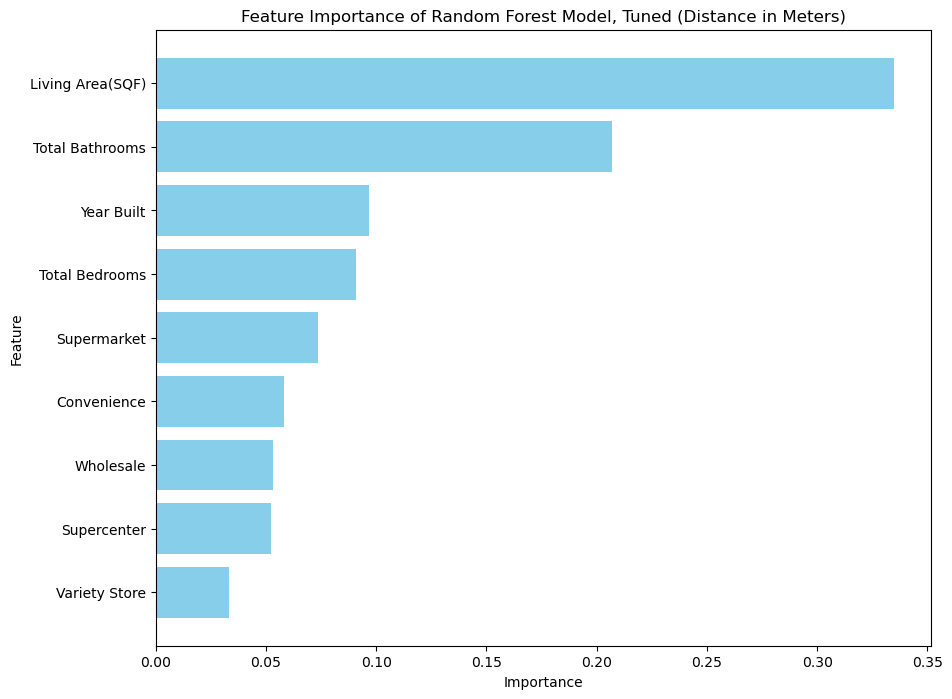

In [56]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

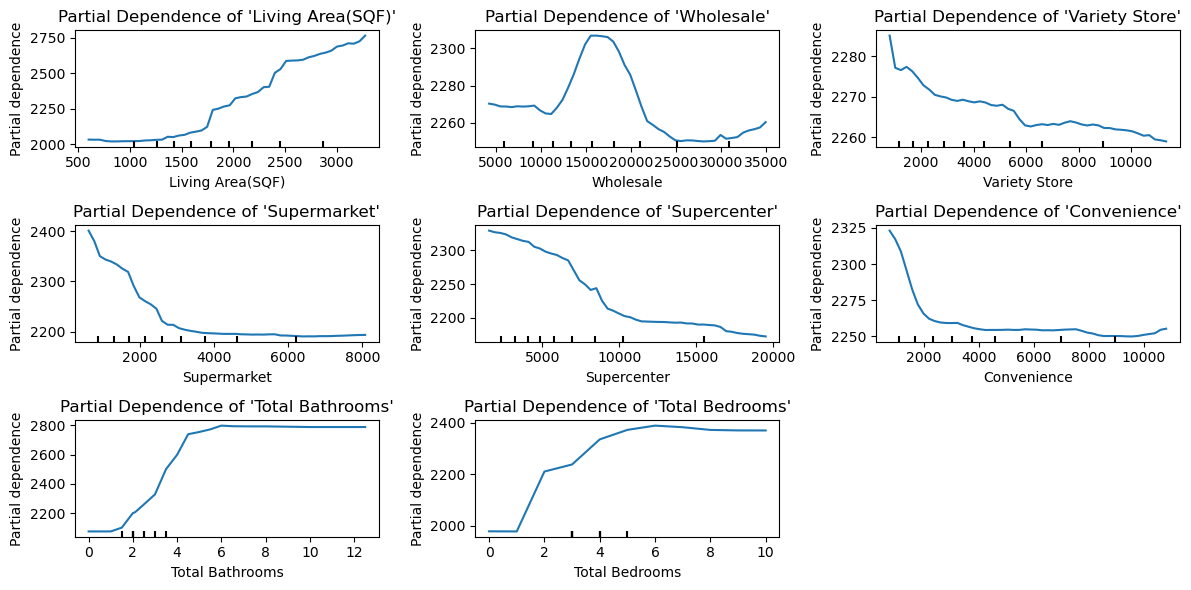

In [57]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# List of features to include in the Partial Dependence Plots
features = [
    'Living Area(SQF)', 'Wholesale', 'Variety Store', 'Supermarket', 
    'Supercenter', 'Convenience', 'Total Bathrooms', 'Total Bedrooms'
]

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model,
        X_train_val,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]  # Place in the correct subplot
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [58]:
Atlanta_Distance_b = Atlanta_Distance.drop(columns=['Wholesale','Variety Store','Supermarket','Supercenter','Convenience'])
numeric_features_b = Atlanta_Distance_b.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
# Combined preprocessor for numeric and nominal
preprocessor_b = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_b)
])
transformed_data_b = preprocessor_b.fit_transform(Atlanta_Distance)
all_feature_names_b = list(numeric_features_b)
transformed_df_b = pd.DataFrame(transformed_data_b, columns=all_feature_names_b)
transformed_df_b

,Year Built,Total Bedrooms,Living Area(SQF),Total Bathrooms
0,5.031097e-01,0.641662,1.314310,0.177326
1,-1.091762e-14,-0.459475,0.111774,-0.475680
2,-1.091762e-14,-0.459475,0.032935,-0.475680
3,-1.091762e-14,-0.459475,-0.704165,-1.781691
4,-1.091762e-14,0.641662,0.623754,-0.475680
...,...,...,...,...
21010,-1.091762e-14,-0.459475,-0.482845,-0.475680
21011,-1.091762e-14,-0.459475,-0.170338,0.177326
21012,1.127320e+00,-0.459475,0.065230,1.483337
21013,-1.091762e-14,0.641662,-0.637674,-0.475680


In [59]:
random_forest_model = RandomForestRegressor(random_state = 42)
pipeline_b = Pipeline([
    ('preprocessor', preprocessor_b),
    ('regressor', random_forest_model)
])

X_b = Atlanta_Distance_b.drop(columns='current_listing_price')
y_b = Atlanta_Distance_b['current_listing_price']
X_train_val_b, X_test_b, y_train_val_b, y_test_b = train_test_split(X_b, y_b, test_size=0.2, random_state=42)
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_val_b, y_train_val_b, test_size=0.25, random_state=42)
pipeline_b.fit(X_train_b, y_train_b)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Total Bathrooms'], dtype='object'))])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [60]:
val_score_b = pipeline_b.score(X_val_b, y_val_b) 
print('Validation R^2:', val_score_b)

test_score_b = pipeline_b.score(X_test_b, y_test_b) 
print('Test R^2:', test_score_b)

Validation R^2: 0.38761673825982434
Test R^2: 0.4083977948418588


In [61]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
param_grid_b = {
    'regressor__n_estimators': [300],
    'regressor__max_depth': [8],
    'regressor__min_samples_split': [2],
    'regressor__min_samples_leaf': [1],
    'regressor__max_features': ['sqrt']
}


grid_search_b = GridSearchCV(
    estimator=pipeline_b,
    param_grid=param_grid_b,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],  # Multiple scoring
    refit='r2',  # Specify which metric to refit
    cv=kf,
    n_jobs=-1,
    verbose=2
)


grid_search_b.fit(X_train_b, y_train_b)

best_model_b = grid_search_b.best_estimator_

# Access the results
results_b = grid_search_b.cv_results_
print("Best parameters:", grid_search_b.best_params_)
print("Best R^2:", grid_search_b.best_score_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best parameters: {'regressor__max_depth': 8, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best R^2: 0.43716460303361265


In [62]:
y_val_pred_tuned_b = best_model_b.predict(X_val_b)
val_scores_b = calculate_scores(y_val_b, y_val_pred_tuned_b)

y_test_pred_tuned_b = best_model_b.predict(X_test_b)
test_scores_b= calculate_scores(y_test_b, y_test_pred_tuned_b)

y_combined_pred_tuned_b = best_model_b.predict(X_train_val_b)
combined_scores_b = calculate_scores(y_train_val_b, y_combined_pred_tuned_b)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_b[0]:.4f}")
print(f"MSE: {val_scores_b[1]:.4f}")
print(f"MAPE: {val_scores_b[2]:.4f}")
print(f"RMSE: {val_scores_b[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_b[0]:.4f}")
print(f"MSE: {test_scores_b[1]:.4f}")
print(f"MAPE: {test_scores_b[2]:.4f}")
print(f"RMSE: {test_scores_b[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_b[0]:.4f}")
print(f"MSE: {combined_scores_b[1]:.4f}")
print(f"MAPE: {combined_scores_b[2]:.4f}")
print(f"RMSE: {combined_scores_b[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.4197
MSE: 484131.0255
MAPE: 0.1718
RMSE: 695.7952

Tuned Test Set Scores:
R²: 0.4316
MSE: 485492.8151
MAPE: 0.1755
RMSE: 696.7731

Tuned Train-Val Set Scores:
R²: 0.5267
MSE: 390247.4735
MAPE: 0.1641
RMSE: 624.6979


In [63]:
best_xgb_model_b = best_model_b.named_steps['regressor']
feature_importances_b = best_xgb_model_b.feature_importances_
sorted_indices_b = np.argsort(feature_importances_b)[::-1]
sorted_feature_importances_b = feature_importances_b[sorted_indices_b]
sorted_feature_names_b = np.array(all_feature_names_b)[sorted_indices_b]
for name, importance in zip(sorted_feature_names_b, sorted_feature_importances_b):
    print(f"Feature: {name}, Importance: {importance:.4f}")

Feature: Living Area(SQF), Importance: 0.4574
Feature: Total Bathrooms, Importance: 0.2622
Feature: Year Built, Importance: 0.1739
Feature: Total Bedrooms, Importance: 0.1065


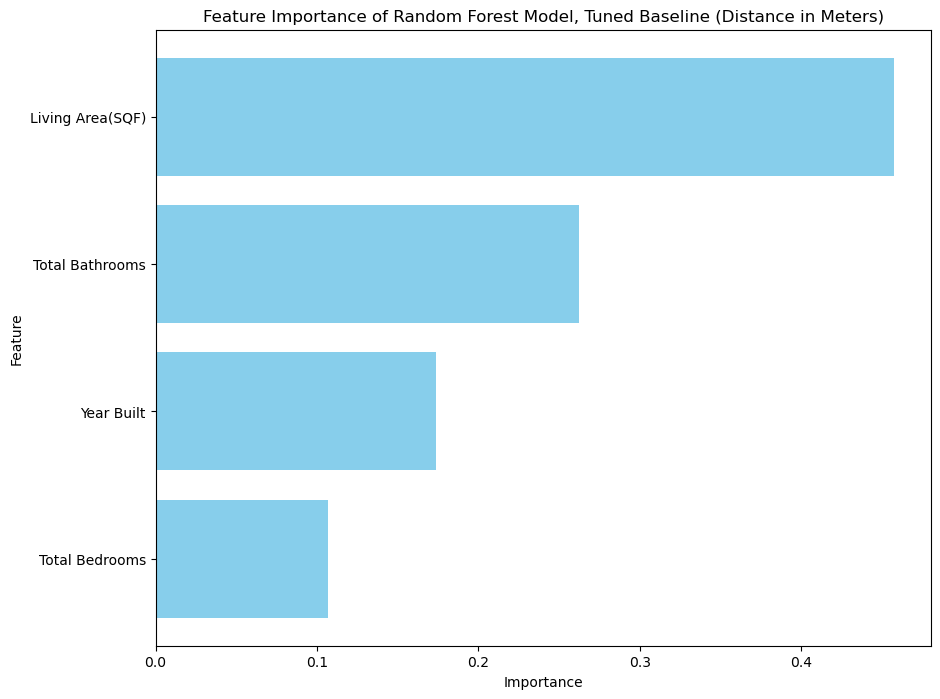

In [64]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names_b, sorted_feature_importances_b, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Model, Tuned Baseline (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

#The feature importance scores remain consistent regardless of the dataset.

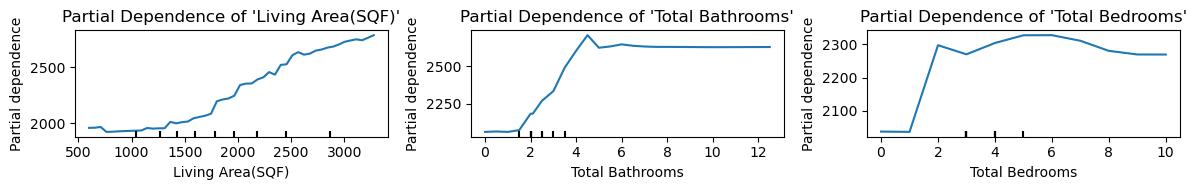

In [65]:
# List of features to include in the Partial Dependence Plots
features = [
    'Living Area(SQF)', 'Total Bathrooms', 'Total Bedrooms'
]

# Set the number of rows and columns for the grid
n_features = len(features)
n_cols = 3  # Number of columns in the grid
n_rows = math.ceil(n_features / n_cols)  # Number of rows

# Create subplots in a grid layout
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, n_rows * 2))

# Flatten axes for easy iteration
axes = axes.ravel()

# Loop through each feature and plot
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        best_model_b,
        X_train_val_b,  # train data?
        [feature],
        grid_resolution=50,
        ax=axes[i]  # Place in the correct subplot
    )
    axes[i].set_title(f"Partial Dependence of '{feature}'")  # Set title for each plot

# Hide any empty subplots (if n_features is not a perfect square)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()